In [2]:
import numpy as np
import os, sys

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
import zarr

from utils import remove_all_ticks_and_labels

# beta vs sigma schedule during forward process

torch.Size([100])


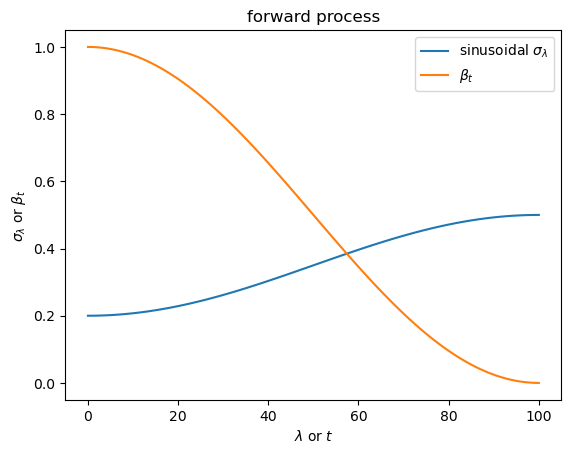

In [134]:
from utils import make_beta_schedule
# b_max = 1e-2
b_max = 0.5
# b_min = 1e-5
b_min = 0.2

sigma_sine = make_beta_schedule(schedule='sine', n_timesteps=100, start=b_min, end=b_max)
# sigma_sigmoid = make_beta_schedule(schedule='sigmoid', n_timesteps=100, start=b_min, end=b_max)
print(sigma_sine.shape)

ls = np.linspace(0, 100, 100)

fig, ax = plt.subplots(1, 1)
ax.set(xlabel='$\lambda$ or $t$', ylabel='$\sigma_\lambda$ or $\\beta_t$')
# ax.plot(ls, sigma_sigmoid, label='sigmoidal $\sigma_\lambda$')

# beta = (b_max-b_min)/2 * (1 + np.cos(np.pi*ls/100)) + b_min
# beta = b_max - sigma_sine + b_min
# beta = 1/2 * (1 + np.cos(np.pi*ls/100))

sigma_sine = (b_max - b_min)/2 * (1 - np.cos(np.pi*ls/100)) + b_min

beta = 1 - (sigma_sine - b_min) / (b_max-b_min)

ax.plot(ls, sigma_sine, label='sinusoidal $\sigma_\lambda$')
ax.plot(ls, beta, label='$\\beta_t$')
ax.legend()
ax.set(title='forward process')
plt.show()

# training a 10 neuron model for a 3d manifold. 

size of the training set is 2000
torch.Size([2000, 10])
size of the training set is 2000


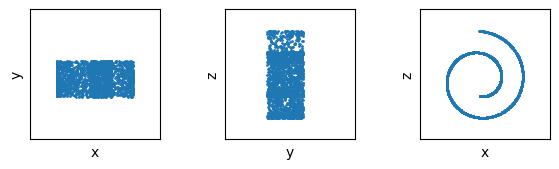

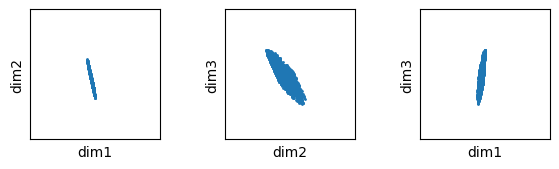

In [135]:
# dataset
from dataset_utils import load_unimodal_data_nd

n_points = int(2e3)

# 2D dataset (not rotated)
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=0, noise=0, shrink_y_axis=True)
print(dataset.shape)

lim=1.5
lims=[-lim, lim]
fig, axes = plt.subplots(1, 3, figsize=(6, 2))
ax = axes[0]
ax.scatter(*dataset[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='y')

ax = axes[1]
ax.scatter(*dataset[:, 1:3].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='y', ylabel='z')

ax = axes[2]
ax.scatter(*dataset[:, (0,2)].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='z')
fig.tight_layout()
for ax in axes:
    remove_all_ticks_and_labels(ax)


# rotated dataset
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
fig, axes = plt.subplots(1, 3, figsize=(6, 2))
ax = axes[0]
ax.scatter(*dataset[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim1', ylabel='dim2')

ax = axes[1]
ax.scatter(*dataset[:, 1:3].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim2', ylabel='dim3')

ax = axes[2]
ax.scatter(*dataset[:, (0,2)].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='dim1', ylabel='dim3')
fig.tight_layout()
for ax in axes:
    remove_all_ticks_and_labels(ax)

(2000, 2)
[0.49738599 0.41364074]
[27.23019125 24.83222138]
[[-0.02728721  0.10668608  0.02859333 -0.51280888  0.53271092  0.0940491
  -0.08445239  0.02294356  0.24461428  0.60329267]
 [-0.07092436  0.31415543 -0.35150268 -0.24118666  0.48147598  0.03645309
  -0.17749984 -0.18458601 -0.25033105 -0.59427199]]


[Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

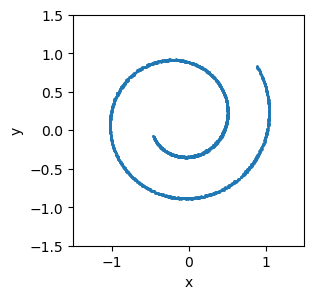

In [136]:
# performing PCA on the rotated dataset
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(dataset)
dataset_2d =pca.transform(dataset)
print(dataset_2d.shape)

print(pca.explained_variance_ratio_)
print(pca.singular_values_)
print(pca.components_)

# plotting the PCA
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.scatter(*dataset_2d[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')
ax.set(xlabel='x', ylabel='y')

this is what we want the generated samples to look like.

In [137]:
# now train model on the 10D dataset
from prior_utils import forward_process
from utils import noise_estimation_loss
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

def reverse_process(model, 
                    model_name, 
                    model_number, 
                    num_steps, 
                    num_hidden, 
                    num_dims,
                    num_epochs,
                    batch_size,
                    lr,
                    device,
                    dataset,
                    pretrained_model):
    
    # beta-related parameters
    coefs = forward_process(num_steps, device)
    betas, alphas, alphas_prod, alphas_prod_p, alphas_bar_sqrt, one_minus_alphas_prod_log, one_minus_alphas_prod_sqrt = coefs
    alphas_bar_sqrt = alphas_bar_sqrt.to(device)
    one_minus_alphas_prod_sqrt = one_minus_alphas_prod_sqrt.to(device)
    
    # training set
    dataset = dataset.to(device)
    
    # define model
    if pretrained_model['use_pretrained_model_weights']:
        from utils import load_model_weights
        pretrained_model_name = pretrained_model['model_name']
        pretrained_model_num = pretrained_model['model_num']
        print(f'taking weights from pretrained model {pretrained_model_name}_{pretrained_model_num}!')
        model = load_model_weights(model, pretrained_model_name, pretrained_model_num, device)
    model.to(device)

    # training parameteres
    optimizer = optim.Adam(model.parameters(), lr=lr)

    run_dir = os.path.join(base_dir, 'demos/runs', f'{model_name}_{model_number}')
    tb = SummaryWriter(run_dir)
    start_time = time.time()
    
    # start training
    model.train()
    for t in trange(int(num_epochs), desc='Training model', unit='epochs'):
        permutation = torch.randperm(dataset.size()[0], device=device)
    
        for i in range(0, dataset.size()[0], batch_size):
            # retrieve current batch
            indices = permutation[i:i+batch_size]
            batch_x = dataset[indices]
            
            # compute the loss
            loss = noise_estimation_loss(model, batch_x, num_steps, alphas_bar_sqrt, one_minus_alphas_prod_sqrt, device, norm='l2', has_class_label=False)
            # zero the gradients
            optimizer.zero_grad()
            # backward pass: compute the gradient of the loss wrt the parameters
            loss.backward()
            # call the step function to update the parameters
            optimizer.step()
        
        # write to tensorboard
        tb.add_scalar('Loss', loss.item(), t)
    tb.flush()

    end_time = time.time()
    duration = end_time - start_time
    duration_mins = duration / 60
    print(f'training took {duration:.0f} seconds, which is {duration_mins:.2f} minutes.')
    return model

In [5]:
import json
from models import VariableDendriticCircuit

# define hyperparameter values
global device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# -------------------------- set model parameters -------------------------- #
model_name = 'unconditional-dendritic'
model_number = 57
num_steps = 100
num_hidden = [3, 3, 3, 3, 3, 3, 4]
num_ambient_dims = 10
num_samples_in_training_set = 1e3
epochs = 3e5
manifold_type = 'swiss_roll_3d'
batch_size = 128
lr = 3e-4
pretrained_model = {
    'use_pretrained_model_weights': True,
    'model_name': 'unconditional-dendritic',
    'model_num': 56
}


# -------------------------- save model description -------------------------- #
description = {
    'model_name': model_name,
    'model_number': model_number,
    'num_steps': num_steps,
    'num_hidden': num_hidden,
    'num_ambient_dims': num_ambient_dims,
    'num_samples_in_training_set': f'{num_samples_in_training_set:.0e}',
    'num_epochs': f'{epochs:.0e}',
    'manifold_type': manifold_type,
    'batch_size': batch_size,
    'learning_rate': f'{lr:.0e}',
    'use_pretrained_model': pretrained_model['use_pretrained_model_weights'],
}
if pretrained_model['use_pretrained_model_weights']:
    description['pretrained_model_name'] = pretrained_model['model_name']
    description['pretrained_model_num'] = pretrained_model['model_num']

json_savedir = os.path.join(base_dir, 'core/model_description')
model_name_and_number = f'{model_name}_{model_number}'
json_name = f'{model_name_and_number}.json'
with open(os.path.join(json_savedir, json_name), 'w') as file:
    json.dump(description, file)


from models import VariableDendriticCircuit
model = VariableDendriticCircuit(hidden_cfg=num_hidden, num_in=num_ambient_dims, num_out=num_ambient_dims, bias=True)
dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)

# -------------------- TRAINING - reverse diffusion process ------------------ #
model = reverse_process(model, model_name, model_number, num_steps, num_hidden, num_ambient_dims, epochs, batch_size, lr, device, dataset, pretrained_model)
from utils import save_model_weights
save_model_weights(model, model_name, model_number)

Using device: cuda
size of the training set is 2000
taking weights from pretrained model unconditional-dendritic_56!
model loaded!


Training model:   0%|          | 0/300000 [00:00<?, ?epochs/s]

Using device: cpu
model loaded!
size of the training set is 2000
torch.Size([101, 1000, 10])


[(-1.5, 1.5), (-1.5, 1.5), None]

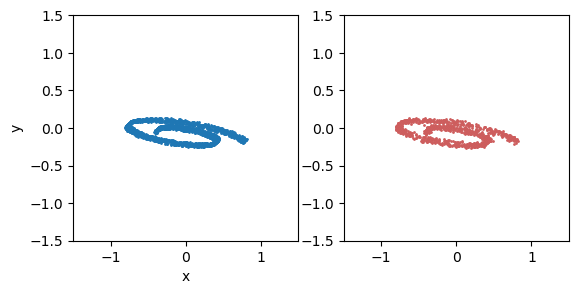

In [139]:
# compare the model output vs ground truth dataset
dim1 = 4
dim2 = 7

# load model and weights
global device
# device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

from utils import select_model
model, num_steps, dim_amb = select_model('unconditional-dendritic', 58)
model = model.to(device)

dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)

fig, ax = plt.subplots(1, 2)
ax[0].scatter(*dataset[:, (dim1, dim2)].T, s=1)
ax[0].set(xlim=lims, ylim=lims, aspect='equal')
ax[0].set(xlabel='x', ylabel='y')

from prior_utils import p_sample_loop
sample_size = int(1e3)
x_seq = p_sample_loop(model, (sample_size, dim_amb), 100, device=device, init_x=None, normalized_beta_schedule=False)
print(x_seq.shape)


cur_x = x_seq[100].detach().cpu()
ax[1].scatter(cur_x[:, dim1], cur_x[:, dim2],color='white',edgecolor='indianred', s=1)
ax[1].set(xlim=lims, ylim=lims, aspect='equal')


(1000, 2)


[(-1.5, 1.5), (-1.5, 1.5), None]

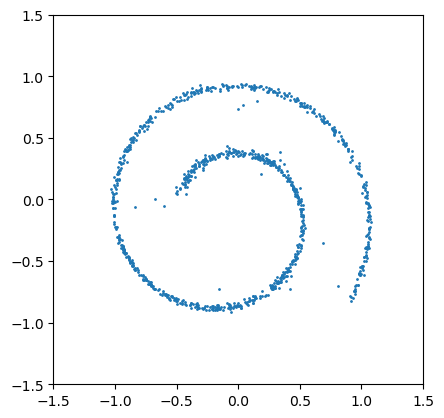

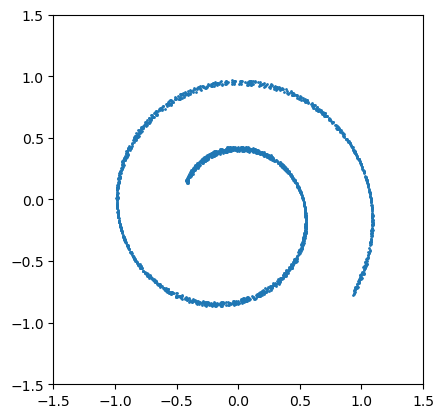

In [147]:
# now perform PCA on the model output
model_output = x_seq[100].detach().cpu()

pca = PCA(n_components=2)
pca.fit(model_output)
x_seq_2d = pca.transform(model_output)
print(x_seq_2d.shape)
eigvalues = pca.components_

fig, ax = plt.subplots(1, 1)
ax.scatter(*x_seq_2d[:, :2].T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')


dataset_2d = (eigvalues @ dataset.detach().cpu().numpy().T).T
fig, ax = plt.subplots(1, 1)
ax.scatter(*dataset_2d.T, s=1)
ax.set(xlim=lims, ylim=lims, aspect='equal')


OR I could just calculate the "ground truth" eigenvalues by rotating the basis vectors in the ambient space by the same angles as the dataset

(2, 10)
size of the training set is 2000
(2000, 10)
(2, 2000)
(100,)
(2, 10, 100)


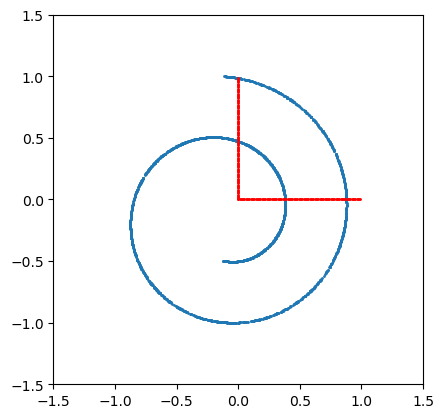

In [206]:
original_basis = np.eye(10)[(0, 2), :]
print(original_basis.shape)

dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=0, noise=0, shrink_y_axis=True)
dataset = dataset.detach().cpu().numpy()
print(dataset.shape)
unrotated_dataset = original_basis @ dataset.T
print(unrotated_dataset.shape)

fig, ax = plt.subplots(1, 1)
ax.set(aspect='equal', xlim=lims, ylim=lims)
ax.scatter(*unrotated_dataset, s=1)

ls = np.arange(0, 1, 0.01)
print(ls.shape)
basis_vectors = np.tensordot(original_basis, ls, axes=0)
print(basis_vectors.shape)

ax.scatter(basis_vectors[0, 0, :], basis_vectors[1, 0, :], color='red', s=1)
ax.scatter(basis_vectors[0, 2, :], basis_vectors[1, 2, :], color='red', s=1)

(2, 10)
size of the training set is 2000
(2, 2000)
(2, 500)


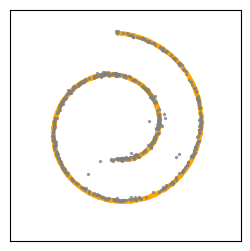

In [257]:
# show the model output during the reverse process, projected onto the 2D PCA space

# rotate the basis vectors by np.pi/4 for each dimension
from dataset_utils import rotate_manifold

n_dims = 10
theta = np.pi/4
rotated_basis = original_basis
# for every axis pair, rotate the vector by angle theta
for i in range(0, n_dims-1):
    for j in range(i+1, n_dims):
        rotated_basis = rotate_manifold(rotated_basis, n_dims, i, j, theta)
rotated_basis = np.array(rotated_basis)
print(rotated_basis.shape)

# plot
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.set(aspect='equal', xlim=lims, ylim=lims)
remove_all_ticks_and_labels(ax)

# project the rotated dataset on the rotated basis vectors
rotated_dataset = load_unimodal_data_nd(n_points, 'swiss_roll_3d', 10, rotation_angle=np.pi/4, noise=0, shrink_y_axis=True)
rotated_dataset = rotated_dataset.detach().cpu().numpy()
projected_rotated_dataset = rotated_basis @ rotated_dataset.T
print(projected_rotated_dataset.shape)
# print(rotated_dataset.shape)
ax.scatter(*projected_rotated_dataset, s=3, c='orange')

# now project the model output onto these rotated basis vectors
model_output = x_seq[100].detach().cpu().numpy()[:500, :]
projected_model_output = rotated_basis @ model_output.T
print(projected_model_output.shape)
ax.scatter(*projected_model_output, s=2, c='grey', alpha=0.7)

now do this for all time steps during the ascending phase of the oscillation 

(101, 1000, 10)


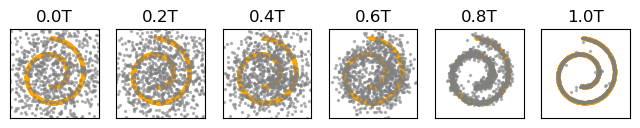

In [272]:
model_output = x_seq.detach().cpu().numpy()
print(model_output.shape)
temps = [0, 20, 40, 60, 80, 100]
fig, ax = plt.subplots(1, len(temps), figsize=(8,3))

for i, t in enumerate(temps):
    projected_model_output = rotated_basis @ model_output[t].T
    ax[i].scatter(*projected_rotated_dataset, s=3, c='orange')
    ax[i].scatter(*projected_model_output, s=2, c='grey', alpha=0.5)
    ax[i].set(aspect='equal', xlim=lims, ylim=lims)
    remove_all_ticks_and_labels(ax[i])
    ax[i].set(title=f'{t/100}T')

# evaluating at mean vs current sample
checking the effect of evaluating the likelihood function at the mean of the prior transition operator $\mu_\theta$ vs at the current sample $\mathbf{x}_t$

In [54]:
from utils import select_model
prior_sampler, num_steps, ambient_dims = select_model('unconditional-dendritic', 47)
from dataset_utils import generate_2d_swiss_roll

v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)
likelihood_sigma = 0.1
s = 0.1

from likelihood_utils import posterior_sample_loop_occlusion, sequential_posterior_sampler
sample_size = int(5e2)

# iid samples from the posterior that uses the continuous likelihood
print('DM')
samples_iid_reverse_xt = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, ambient_dims), num_steps, eval_at_mean=False)
samples_iid_reverse_mu = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, ambient_dims), num_steps, eval_at_mean=True)

# sequential samples from the posterior that uses the continuous likelihood
print('neural sampling')
num_samples_in_gt_manifold = int(1e3)
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]
manifold_initial_point = dataset[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
z_seq_xt, samples_seq_reverse_xt = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles=sample_size, eval_at_mean=False)
z_seq_mu, samples_seq_reverse_mu = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles=sample_size, eval_at_mean=True)

model loaded!
DM
neural sampling


iid samples

[Text(0, 0.5, 'eval at sample $\\mu_\\theta$')]

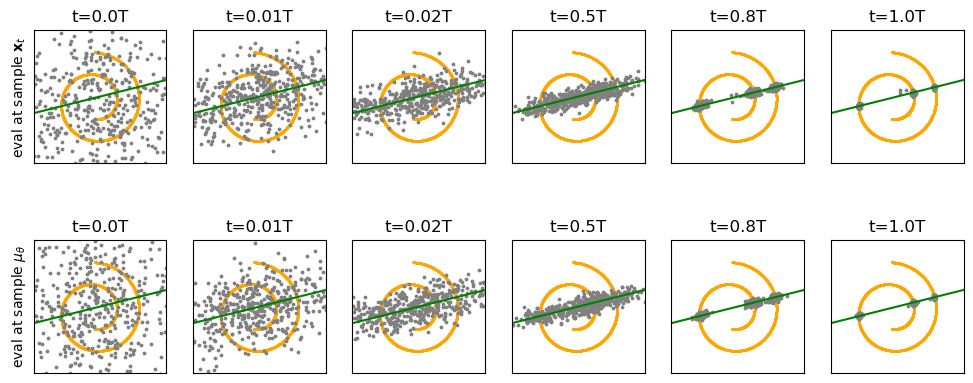

In [77]:
from plot import draw_constraint_line
# plot the distributions
temps = [0, 1, 2, 50, 80, 100]
lim=1.5
lims = [-lim, lim]

# plot the reverse process of the iid generated posterior samples at different temperatures
fig, ax = plt.subplots(2, len(temps), figsize=(12, 5), sharex=True, sharey=True)
idx = 0
for i, temp in enumerate(temps):
    for j in range(2):
        if j == 0:
            ax[j, i].scatter(*dataset.T, s=1, c='orange')
            ax[j, i].scatter(*samples_iid_reverse_xt[int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
            draw_constraint_line(ax[j, i], v, likelihood_sigma, lim, show_stdev=False)
            ax[j, i].set(title=f't={int(temp)/100}T')
            ax[j, i].set(xlim=lims, ylim=lims, aspect='equal')
            remove_all_ticks_and_labels(ax[j, i])
        if j == 1:
            ax[j, i].scatter(*dataset.T, s=1, c='orange')
            ax[j, i].scatter(*samples_iid_reverse_mu[int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
            draw_constraint_line(ax[j, i], v, likelihood_sigma, lim, show_stdev=False)
            ax[j, i].set(title=f't={int(temp)/100}T')
            ax[j, i].set(xlim=lims, ylim=lims, aspect='equal')
            remove_all_ticks_and_labels(ax[j, i])
ax[0, 0].set(ylabel='eval at sample $\mathbf{x}_t$')
ax[1, 0].set(ylabel='eval at sample $\mu_\\theta$')

neural sampling

[Text(0, 0.5, 'eval at sample $\\mu_\\theta$')]

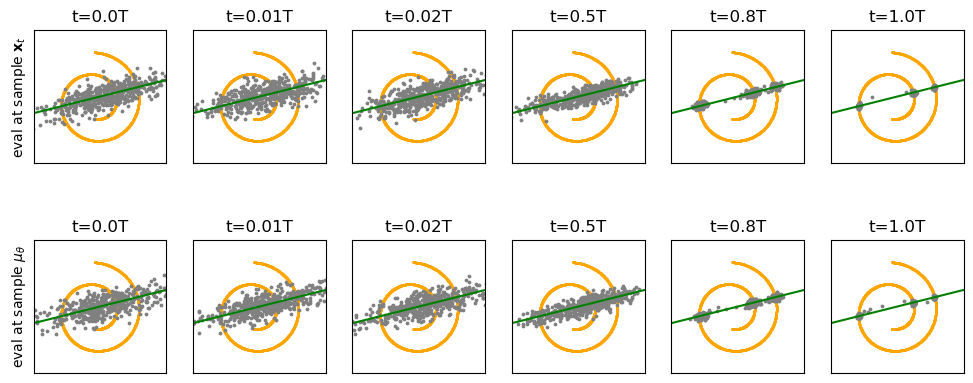

In [78]:
from plot import draw_constraint_line
# plot the distributions
temps = [0, 1, 2, 50, 80, 100]
lim=1.5
lims = [-lim, lim]

# plot the reverse process of the iid generated posterior samples at different temperatures
fig, ax = plt.subplots(2, len(temps), figsize=(12, 5), sharex=True, sharey=True)
idx = 0
for i, temp in enumerate(temps):
    for j in range(2):
        if j == 0:
            ax[j, i].scatter(*dataset.T, s=1, c='orange')
            ax[j, i].scatter(*samples_seq_reverse_xt[:, int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
            draw_constraint_line(ax[j, i], v, likelihood_sigma, lim, show_stdev=False)
            ax[j, i].set(title=f't={int(temp)/100}T')
            ax[j, i].set(xlim=lims, ylim=lims, aspect='equal')
            remove_all_ticks_and_labels(ax[j, i])
        if j == 1:
            ax[j, i].scatter(*dataset.T, s=1, c='orange')
            ax[j, i].scatter(*samples_seq_reverse_mu[:, int(temp)].T, s=3, c='grey', label='$p(z_t\,|\,M^T z_t)$')
            draw_constraint_line(ax[j, i], v, likelihood_sigma, lim, show_stdev=False)
            ax[j, i].set(title=f't={int(temp)/100}T')
            ax[j, i].set(xlim=lims, ylim=lims, aspect='equal')
            remove_all_ticks_and_labels(ax[j, i])
ax[0, 0].set(ylabel='eval at sample $\mathbf{x}_t$')
ax[1, 0].set(ylabel='eval at sample $\mu_\\theta$')

now calculate the KL divergence between the iid and sequential samples

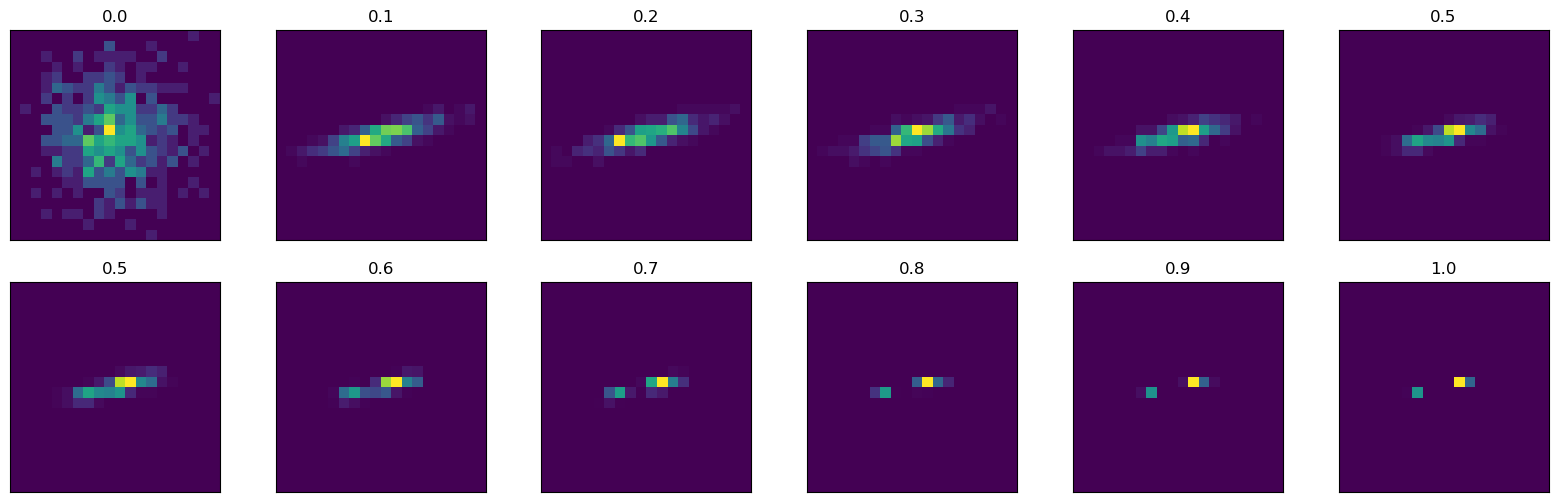

In [103]:
# now calculate the histogram of samples from the amortized posterior for all thetas
from likelihood_utils import calculate_histogram_for_seq_data, calculate_histogram_for_iid_data

# iid
histograms_iid_xt = calculate_histogram_for_iid_data(samples_iid_reverse_xt, num_bins=20, lim=3)
histograms_iid_mu = calculate_histogram_for_iid_data(samples_iid_reverse_mu, num_bins=20, lim=3)

# sequential
histograms_seq_xt = calculate_histogram_for_seq_data(samples_seq_reverse_xt, num_bins=20, lim=3)
histograms_seq_mu = calculate_histogram_for_seq_data(samples_seq_reverse_mu, num_bins=20, lim=3)



histograms = histograms_iid_mu

# plot for xt
fig, ax = plt.subplots(2, 6, figsize=(20, 6))
idx0 = 0
idx1 = 0
for h, hist in enumerate(histograms):
    if h in [0, 10, 20, 30, 40, 50]:
        a = ax[0, idx0]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx0 += 1
    if h in [50, 60, 70, 80, 90, 100]:
        a = ax[1, idx1]
        a.set_aspect('equal')
        a.set(title=f'{h/100}')
        a.imshow(hist.T, origin='lower')
        remove_all_ticks_and_labels(a)
        idx1 += 1

now we can calculate the KL divergence between the xt and mu based samples

In [114]:
from scipy.stats import entropy

# can't compute KL divergence when bins are empty, so a (biased) solution is to a small epsilon to each bin
epsilon = 1e-5  

# ------------------------------------ iid ----------------------------------- #
p = histograms_iid_mu + epsilon  # xt distribution
q = histograms_iid_xt + epsilon  # mu distribution

entropies_iid = []
for phi in range(len(histograms_iid_mu)):
    p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
    q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
    entropies_iid.append(entropy(p_phi, q_phi))
entropies_iid = np.stack(entropies_iid)


# -------------------------------- sequential -------------------------------- #
p = histograms_seq_mu + epsilon  # xt distribution

q = histograms_seq_xt + epsilon  # mu distribution

entropies_seq = []
for phi in range(len(histograms_seq_mu)):
    p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
    q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
    entropies_seq.append(entropy(p_phi, q_phi))
entropies_seq = np.stack(entropies_seq)

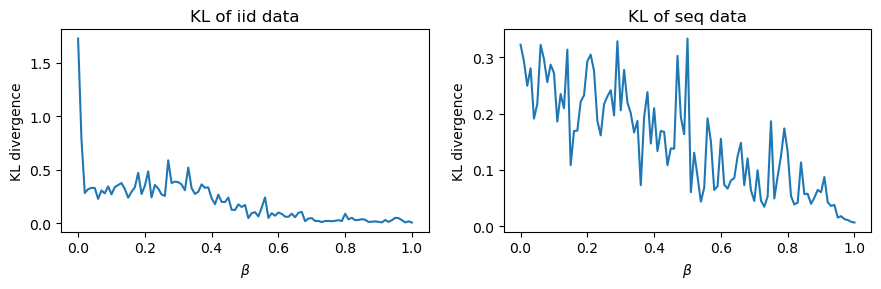

In [119]:
fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ls = np.linspace(0, 1, len(entropies_seq))
ax[0].plot(ls, entropies_iid)
ax[0].set(title='KL of iid data', ylabel='KL divergence', xlabel='$\\beta$')
# ax[0].set(yticks=[0, 0.5, 1, 1.5, 2])

ax[1].plot(ls, entropies_seq)
ax[1].set(title='KL of seq data', ylabel='KL divergence', xlabel='$\\beta$')

fig.tight_layout()

now run this 100 times to get the mean and std of the KL divergence 

In [129]:
from utils import select_model
prior_sampler, num_steps, ambient_dims = select_model('unconditional-dendritic', 47)
from dataset_utils import generate_2d_swiss_roll

v = np.array([[4, 1]]).T
M = v / np.linalg.norm(v)
likelihood_sigma = 0.1
s = 0.1

from likelihood_utils import posterior_sample_loop_occlusion, sequential_posterior_sampler
sample_size = int(5e2)
num_samples_in_gt_manifold = int(1e3)
dataset = generate_2d_swiss_roll(num_samples_in_gt_manifold, True)[1]

num_runs = 200
# --------------------- run the reverse process 100 times -------------------- #
samples_iid_reverse_xts = []
samples_iid_reverse_mus = []
samples_seq_reverse_xts = []
samples_seq_reverse_mus = []

for i in trange(num_runs):
    # iid samples from the posterior that uses the continuous likelihood
    samples_iid_reverse_xt = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, ambient_dims), num_steps, eval_at_mean=False)
    samples_iid_reverse_xts.append(samples_iid_reverse_xt)
    samples_iid_reverse_mu = posterior_sample_loop_occlusion(prior_sampler, M, likelihood_sigma, s, (sample_size, ambient_dims), num_steps, eval_at_mean=True)
    samples_iid_reverse_mus.append(samples_iid_reverse_mu)

    # sequential samples from the posterior that uses the continuous likelihood
    manifold_initial_point = dataset[np.random.randint(num_samples_in_gt_manifold)].reshape(1, -1)
    samples_seq_reverse_xt = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles=sample_size, eval_at_mean=False)[1]
    samples_seq_reverse_xts.append(samples_seq_reverse_xt)
    samples_seq_reverse_mu = sequential_posterior_sampler(prior_sampler, manifold_initial_point, M, likelihood_sigma, s, num_cycles=sample_size, eval_at_mean=True)[1]
    samples_seq_reverse_mus.append(samples_seq_reverse_mu)

samples_iid_reverse_xts = np.stack(samples_iid_reverse_xts)
samples_iid_reverse_mus = np.stack(samples_iid_reverse_mus)
print(samples_iid_reverse_xts.shape)



model loaded!


  0%|          | 0/200 [00:00<?, ?it/s]

(200, 101, 500, 2)
(200, 101, 20, 20)
(200, 101)


In [275]:
# now calculate the histogram of samples from the amortized posterior for all thetas
from likelihood_utils import calculate_histogram_for_seq_data, calculate_histogram_for_iid_data

num_bins_per_dim = 15
domain_range = 3

histograms_iid_xts = []
histograms_iid_mus = []
histograms_seq_xts = []
histograms_seq_mus = []

for i in range(num_runs):
    # iid
    histograms_iid_xt = calculate_histogram_for_iid_data(samples_iid_reverse_xts[i], num_bins_per_dim, domain_range)
    histograms_iid_mu = calculate_histogram_for_iid_data(samples_iid_reverse_mus[i], num_bins_per_dim, domain_range)

    # sequential
    histograms_seq_xt = calculate_histogram_for_seq_data(samples_seq_reverse_xts[i], num_bins_per_dim, domain_range)
    histograms_seq_mu = calculate_histogram_for_seq_data(samples_seq_reverse_mus[i], num_bins_per_dim, domain_range)

    histograms_iid_xts.append(histograms_iid_xt)
    histograms_iid_mus.append(histograms_iid_mu)
    histograms_seq_xts.append(histograms_seq_xt)
    histograms_seq_mus.append(histograms_seq_mu)

histograms_iid_xts = np.stack(histograms_iid_xts)
histograms_iid_mus = np.stack(histograms_iid_mus)
histograms_seq_xts = np.stack(histograms_seq_xts)
histograms_seq_mus = np.stack(histograms_seq_mus) 
print(histograms_iid_xts.shape)


from scipy.stats import entropy

# can't compute KL divergence when bins are empty, so a (biased) solution is to a small epsilon to each bin
epsilon = 1e-5  

entropies_iids = []
entropies_seqs = []

for i in range(num_runs):
    # ------------------------------------ iid ----------------------------------- #
    p = histograms_iid_mus[i] + epsilon  # xt distribution
    q = histograms_iid_xts[i] + epsilon  # mu distribution

    entropies_iid = []
    for phi in range(len(histograms_iid_mus[i])):
        p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
        q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
        entropies_iid.append(entropy(p_phi, q_phi))
    entropies_iid = np.stack(entropies_iid)
    entropies_iids.append(entropies_iid)


    # -------------------------------- sequential -------------------------------- #
    p = histograms_seq_mus[i] + epsilon  # xt distribution
    q = histograms_seq_xts[i] + epsilon  # mu distribution

    entropies_seq = []
    for phi in range(len(histograms_seq_mus[i])):
        p_phi = p[phi].flatten() / np.sum(p[phi])  # turn into a vector and then normalize
        q_phi = q[phi].flatten() / np.sum(q[phi])  # turn into a vector and then normalize
        entropies_seq.append(entropy(p_phi, q_phi))
    entropies_seq = np.stack(entropies_seq)
    entropies_seqs.append(entropies_seq)

entropies_iids = np.stack(entropies_iids)
entropies_seqs = np.stack(entropies_seqs)
print(entropies_iids.shape)

(200, 101, 15, 15)
(200, 101)


[(0.0, 0.5)]

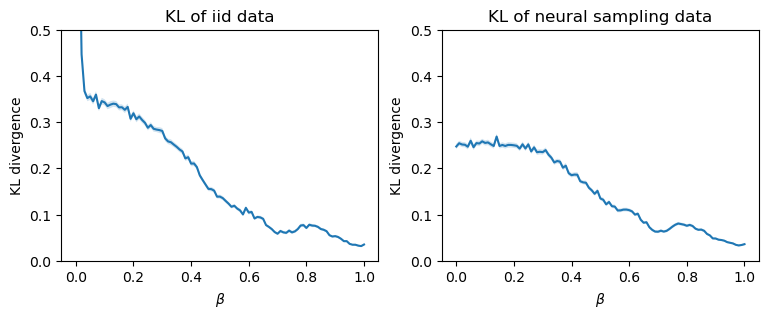

In [ ]:
mean_entropy_iid = np.mean(entropies_iids, axis=0)
mean_entropy_seq = np.mean(entropies_seqs, axis=0)
std_entropy_iid = np.std(entropies_iids, axis=0) /  np.sqrt(num_runs)
std_entropy_seq = np.std(entropies_seqs, axis=0) / np.sqrt(num_runs)

fig, ax = plt.subplots(1, 2, figsize=(9, 3))
ls = np.linspace(0, 1, len(mean_entropy_seq))
ax[0].plot(ls, mean_entropy_iid)
ax[0].fill_between(ls, mean_entropy_iid-std_entropy_iid, mean_entropy_iid+std_entropy_iid, alpha=0.2)
ax[0].set(title='KL of iid data', ylabel='KL divergence', xlabel='$\\beta$')
ax[0].set(ylim=[0, 0.5])

ax[1].plot(ls, mean_entropy_seq)
ax[1].fill_between(ls, mean_entropy_seq-std_entropy_seq, mean_entropy_seq+std_entropy_seq, alpha=0.2)
ax[1].set(title='KL of neural sampling data', ylabel='KL divergence', xlabel='$\\beta$')
ax[1].set(ylim=[0, 0.5])

In [131]:
# save data
import zarr
# zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'iid_xts.zarr'), histograms_iid_xts)
# zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'iid_mus.zarr'), histograms_iid_mus)
# zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'seq_xts.zarr'), histograms_seq_xts)
# zarr.save(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'seq_mus.zarr'), histograms_seq_mus)
histograms_iid_xts = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'iid_xts.zarr'))
histograms_iid_mus = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'iid_mus.zarr'))
histograms_seq_xts = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'seq_xts.zarr'))
histograms_seq_mus = zarr.load(os.path.join(base_dir, 'core/saved_arrays/eval_loc', 'seq_mus.zarr'))

# effect of discretization 
I want to check how the discretization affects the quality of the samples. Does it at all? 

# learning
How does the sample quality change over learning?